## Loading the dataset 

In [1]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 209 kB 45.2 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 170 kB 79.1 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 62 kB 835 kB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requ

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/n2DalgUeTL0HZBbMVVFMuLUkk3BCqMbkhDPoJP20G98
API Key valid
Saved API Key successfully!


In [3]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c starship-detection -o data

data.zip:   0%|          | 0.00/34.1M [00:00<?, ?B/s]

In [4]:
!unzip data/data.zip -d /content/images >> /dev/null

## Actual code starts from here

In [5]:
# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

# Misc.
import pandas as pd
from tqdm.notebook import tqdm
import os
from natsort import natsorted

In [42]:
def load_image_n_transform(img):
  np_img              = np.array(img)
  gray                = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
  if gray.mean()>200:
    # gray                = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    canny               = cv2.Canny(gray, 120,150)
  else:
    # gray                = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    canny               = cv2.Canny(gray, 50,200)
  contours, hierarchy = cv2.findContours(canny,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours            = sorted(contours, key=cv2.contourArea)
  return contours

In [43]:
def get_parameters(contours,extent):
  '''
      Input the contours and the extent till which we need to extract bounding-boxes
  '''

  bounds = min(len(contours),extent)
  x_axis = []
  y_axis = []
  width  = []
  height = []
  for i in range(1,bounds+1,1):
    x,y,w,h = list(cv2.boundingRect(contours[-1*i]))
    x_axis.append(x)
    y_axis.append(y)
    width.append(w)
    height.append(h)
  return (x_axis,y_axis,width,height)

def get_optimal_parameters(contours,extent):
  
  parameters   = get_parameters(contours,extent)
  x_parameter  = np.array(parameters[0])
  y_parameter  = np.array(parameters[1])
  width_param  = np.array(parameters[2])
  height_param = np.array(parameters[3])

  length       = len(x_parameter)

  x            = np.min(x_parameter)

  y            = np.min(y_parameter)

  width        = np.max(x_parameter+width_param)-x

  height       = np.max(y_parameter+height_param)-y

  return [x,y,x+width,y+height]
  

Reading image  7987


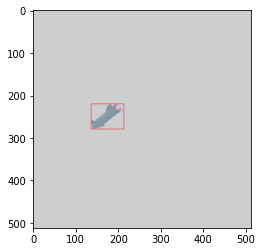

Reading image  7725


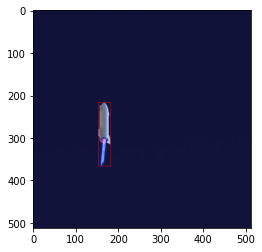

Reading image  6842


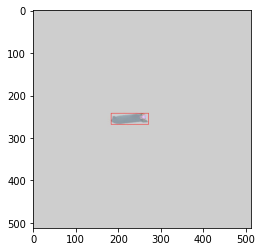

Reading image  445


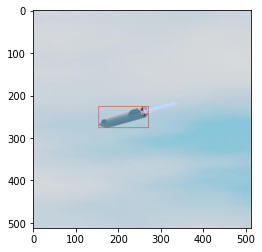

Reading image  7724


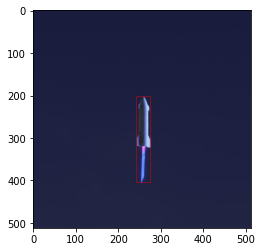

Reading image  7371


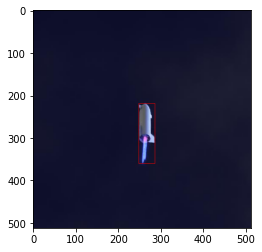

Reading image  5703


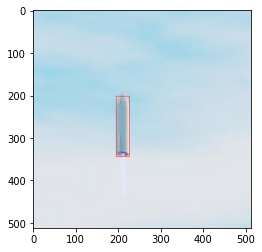

Reading image  3384


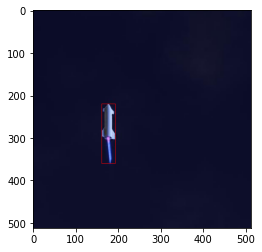

Reading image  9868


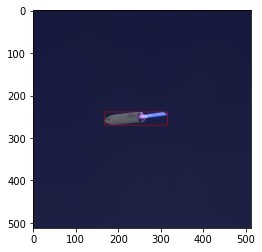

Reading image  626


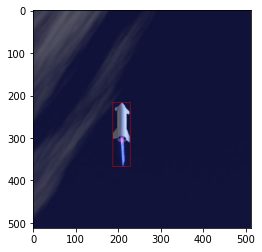

Reading image  4088


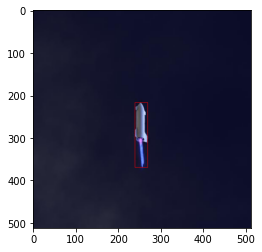

Reading image  3443


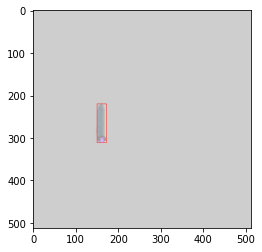

Reading image  2469


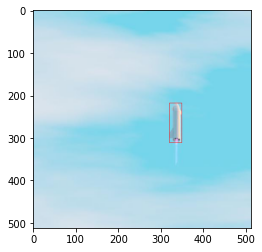

Reading image  865


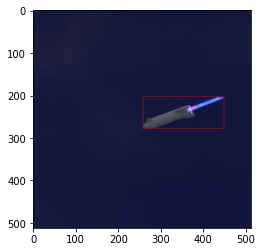

Reading image  7629


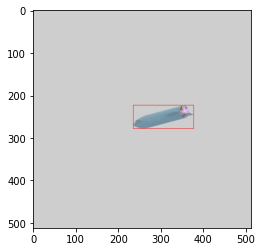

Reading image  4412


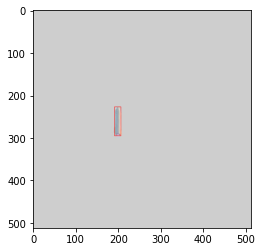

Reading image  4978


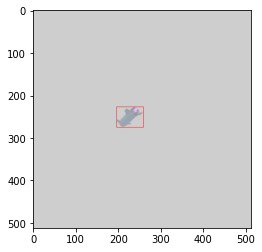

Reading image  5177


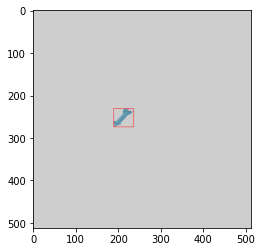

Reading image  1246


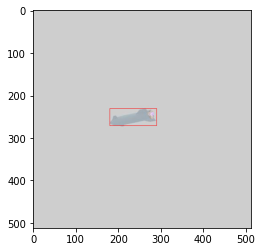

Reading image  5695


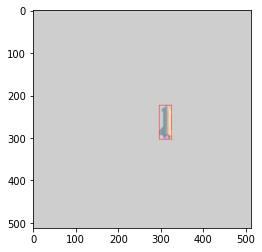

In [52]:
image_ind  = str(random.choice(range(1,10000+1)))

for i in range(20):
  image_ind  = str(random.choice(range(1,10000+1)))
  print(f'Reading image  {image_ind}')
  # image_ind = 2001
  img               = Image.open(f"images/{image_ind}.jpg")
  contours          = load_image_n_transform(img)#,50,200,120,150)
  # contours          = load_image_n_transform(img,100,150,100,150)
  parameters        = get_optimal_parameters(contours,13)
  # Showing the contour
  draw_img = img.copy()
  draw = ImageDraw.Draw(draw_img)
  draw.rectangle(parameters, outline ="red")
  # draw_img
  plt.imshow(draw_img)
  plt.show()

In [53]:
test_imgs = natsorted(os.listdir("images"))
print(len(test_imgs))

10000


In [54]:
# Function to generate the bounding boxes
def gen_bounding_boxes(img):

  # Converting the image to numpy array 
  img = np.array(img)
  

  try:
    # Return the boundong boxes of the biggest contour
    contours   = load_image_n_transform(img)
    parameters = get_optimal_parameters(contours,13)
    
    x = parameters[0]
    y = parameters[1]
    w = parameters[2]-x
    h = parameters[3]-y
  except:
    x,y,w,h = [1, 1, 1, 1]

  return x,y,w,h


In [55]:
bboxes = []
image_ids = []

# Ground through each test image
for img_name in tqdm(test_imgs):

  # Reading the test image
  img = Image.open(os.path.join("images", img_name))

  # Generating the bounding boxes
  x,y,w,h = gen_bounding_boxes(img)

  # Adding the boundong boxes and image id
  bboxes.append([x,y,w,h])
  image_ids.append(int(img_name.split(".")[0]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
# Adding the image id and bounding boxes to a dataframe
df = pd.DataFrame({"ImageID":image_ids, "bbox":bboxes})
df = df.sort_values("ImageID").reset_index(drop=True)
df

ImageID                 bbox
0           0   [167, 215, 20, 98]
1           1  [273, 228, 128, 42]
2           2   [246, 220, 32, 97]
3           3  [204, 243, 168, 33]
4           4  [321, 214, 34, 105]
...       ...                  ...
9995     9995  [191, 240, 196, 30]
9996     9996   [180, 245, 71, 21]
9997     9997   [96, 208, 206, 80]
9998     9998   [157, 220, 24, 97]
9999     9999  [163, 200, 24, 128]

[10000 rows x 2 columns]

In [57]:
!rm -rf assets
!mkdir assets

df.to_csv(os.path.join("assets", "submission.csv"), index=False)

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
